# Sales & Demand Forecasting using Machine Learning

### Future Interns – Machine Learning Task 1 (2026)

This project builds a time-series sales forecasting system using historical retail data.

Objective:
Objective: To predict future daily sales and generate actionable business insights using machine learning techniques

## Business Objective

Sales forecasting helps businesses:
- Plan inventory
- Manage staffing
- Avoid overstocking
- Improve cash flow planning

The goal of this project is to predict daily sales
using historical data and machine learning.

## Data Loading and Exploration

The dataset contains retail transaction data with dates and sales values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/superstore.csv", encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Dataset Inspection and Preprocessing

The dataset was explored using `.info()` and `.describe()` 
to understand its structure, data types, and summary statistics.

Key Observations:
- The dataset contains 9,994 transaction records.
- There are 21 columns including sales, quantity, discount, and profit.
- No missing values were observed.
- The "Order Date" column was originally stored as an object (string).

To enable time-series analysis, the "Order Date" column 
was converted into datetime format.

In [2]:
df.info()
df.describe()
df['Order Date'] = pd.to_datetime(df['Order Date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

## Time Series Conversion

Transactions were aggregated into daily total sales 
by grouping data by "Order Date" and summing the sales values.

The resulting dataset represents a continuous daily time series, 
which is suitable for trend analysis and forecasting.

In [3]:
# Group by Order Date and sum sales
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

# Sort by date
daily_sales = daily_sales.sort_values('Order Date')

# Set Date as index
daily_sales.set_index('Order Date', inplace=True)

daily_sales.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,4407.100
2014-01-07,87.158


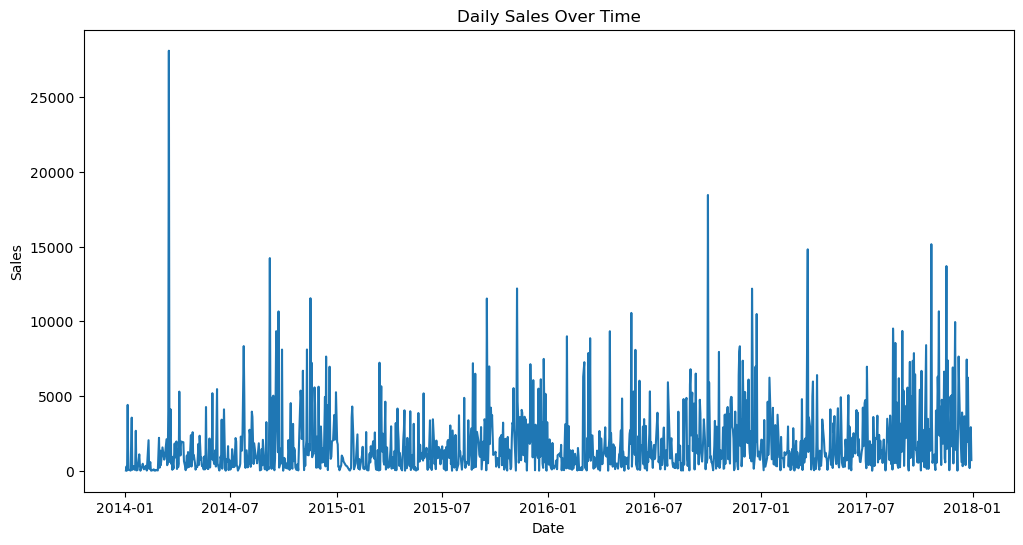

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_sales)
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

### Observations from Daily Sales Trend

- Sales exhibit high daily volatility.
- Several spikes indicate bulk purchases or seasonal demand.
- A gradual upward trend is visible toward later years.
- The data contains strong variability, making forecasting meaningful and challenging.

## Feature Engineering

Calendar-based time features were created from the datetime index 
to help the model capture seasonal and weekly patterns in sales behavior.

The following features were engineered:
- **day** → Day of the month
- **month** → Month of the year
- **year** → Year component
- **day_of_week** → Day of week (0 = Monday, 6 = Sunday)
- **week_of_year** → Week number in the year
These features allow the model to learn recurring seasonal patterns.

In [5]:
daily_sales['day'] = daily_sales.index.day
daily_sales['month'] = daily_sales.index.month
daily_sales['year'] = daily_sales.index.year
daily_sales['day_of_week'] = daily_sales.index.dayofweek
daily_sales['week_of_year'] = daily_sales.index.isocalendar().week

daily_sales.head()

,Sales,day,month,year,day_of_week,week_of_year
Order Date,,,,,,
2014-01-03,16.448,3,1,2014,4,1
2014-01-04,288.060,4,1,2014,5,1
2014-01-05,19.536,5,1,2014,6,1
2014-01-06,4407.100,6,1,2014,0,2
2014-01-07,87.158,7,1,2014,1,2


## Train-Test Split

A time-based split was applied to preserve temporal order.

- Training data: Before 2017
- Testing data: 2017 onward

This prevents data leakage and ensures realistic evaluation.

In [6]:
train = daily_sales[daily_sales.index < '2017-01-01']
test = daily_sales[daily_sales.index >= '2017-01-01']

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (915, 6)
Test size: (322, 6)


## Baseline Random Forest Model

An initial Random Forest Regressor was trained using 
calendar-based time features to establish a baseline forecasting model.

Random Forest was selected due to its ability to capture 
non-linear patterns in time-series data.

In [7]:
features = ['day', 'month', 'year', 'day_of_week', 'week_of_year']

X_train = train[features]
y_train = train['Sales']

X_test = test[features]
y_test = test['Sales']

In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

### Actual vs Predicted Sales

The following plot compares real sales values 
with model predictions on the test dataset.

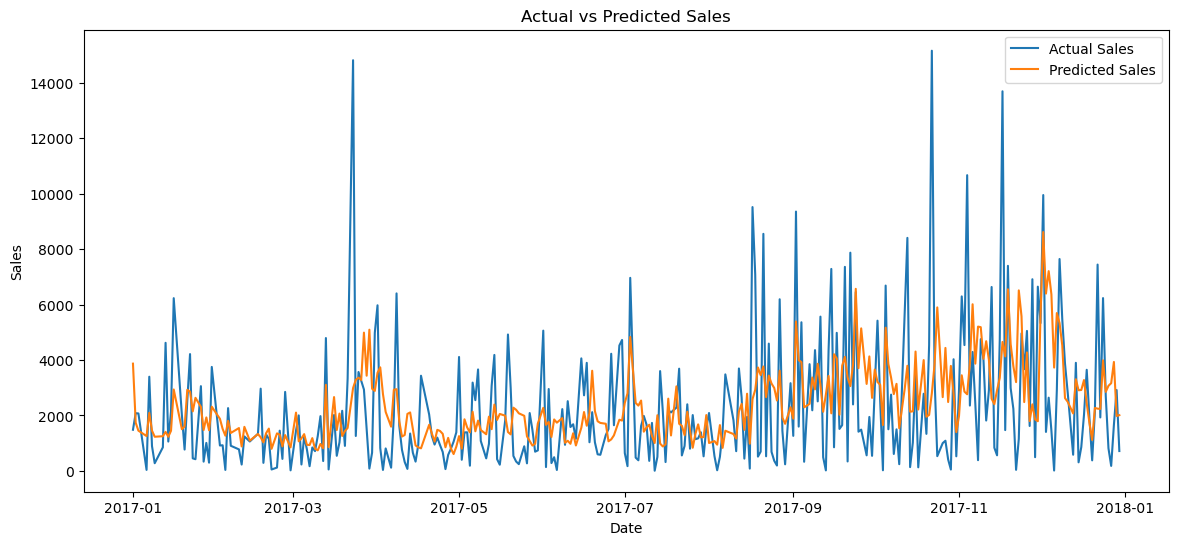

In [24]:
plt.figure(figsize=(14,6))
plt.plot(test.index, y_test, label="Actual Sales")
plt.plot(test.index, predictions, label="Predicted Sales")
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 1675.2350714891304
Root Mean Squared Error: 2517.344053258259


### Baseline Model Performance

- **Mean Absolute Error (MAE)** measures the average absolute difference 
  between actual and predicted sales.
- **Root Mean Squared Error (RMSE)** penalizes larger errors 
  and provides insight into prediction stability.

The baseline model captures overall sales trends 
but struggles with extreme spikes in daily demand.

Given the high volatility observed in daily sales,
these error values indicate that the model captures 
general trends reasonably well but does not fully 
account for sudden demand surges.

## 30-Day Future Sales Forecast

Using the trained baseline Random Forest model, 
future sales for the next 30 days were predicted 
based on calendar-derived features.
This provides a short-term outlook for business planning.

In [11]:
# Create next 30 days

last_date = daily_sales.index.max()

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

future_df = pd.DataFrame(index=future_dates)

future_df['day'] = future_df.index.day
future_df['month'] = future_df.index.month
future_df['year'] = future_df.index.year
future_df['day_of_week'] = future_df.index.dayofweek
future_df['week_of_year'] = future_df.index.isocalendar().week

future_predictions = model.predict(future_df[features])

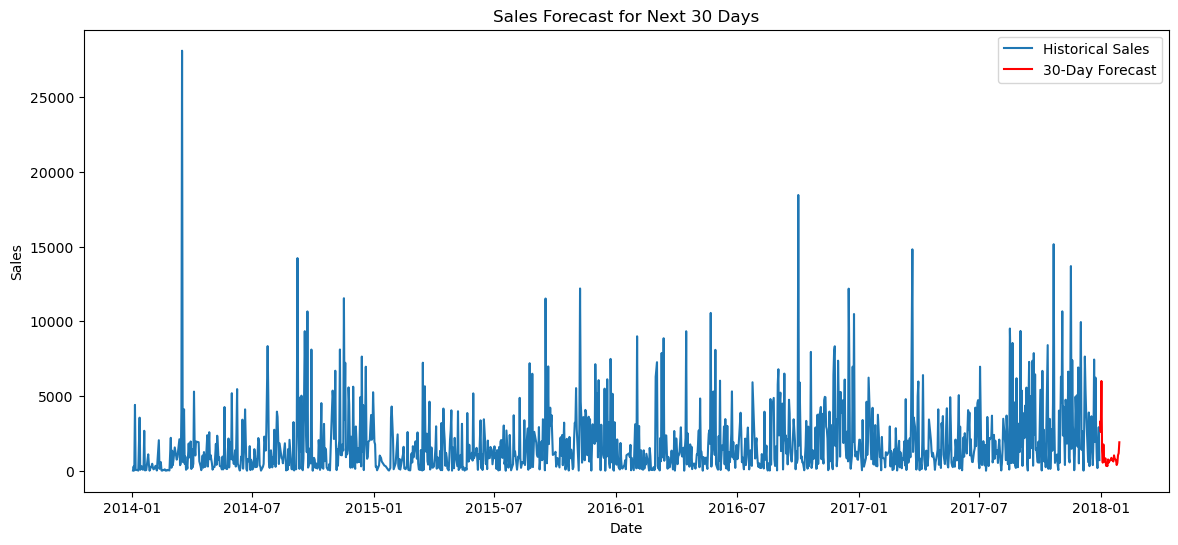

In [12]:
plt.figure(figsize=(14,6))

plt.plot(daily_sales.index, daily_sales['Sales'], label="Historical Sales")
plt.plot(future_df.index, future_predictions, label="30-Day Forecast", color="red")

plt.legend()
plt.title("Sales Forecast for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

### Forecast Insights

- The forecast reflects continued daily volatility.
- Predicted values stay within historical demand range.
- Large spikes remain difficult to anticipate in the baseline model.

This reinforces the need for improved feature engineering,
such as lag-based historical features.

## Monthly Sales Trend Analysis

To better understand long-term growth and seasonality, 
daily sales were aggregated into monthly totals. 
This reduces short-term volatility and highlights broader business patterns.

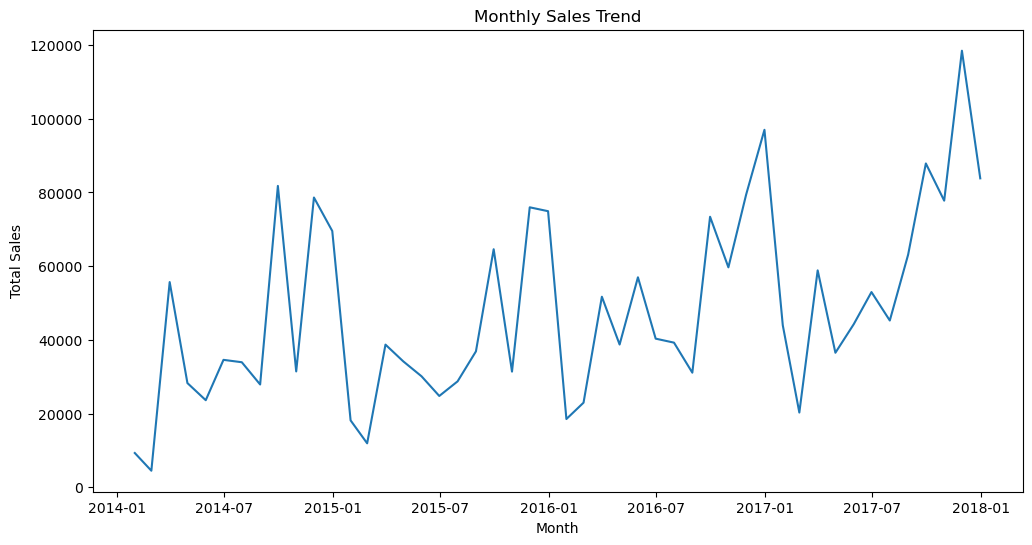

In [25]:
# Monthly Aggregation
monthly_sales = daily_sales['Sales'].resample('ME').sum()

plt.figure(figsize=(12,6))
plt.plot(monthly_sales)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

### Monthly Trend Insights

- Sales show an overall upward growth trend.
- Seasonal fluctuations are visible across years.
- Peak months indicate high-demand seasonal cycles.

This helps businesses plan inventory and marketing campaigns at a strategic level.

## Feature Importance Analysis

Feature importance helps identify which variables 
most influence the sales predictions in the Random Forest model.

In [14]:
import pandas as pd

importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

importance

,Feature,Importance
0,day,0.376543
3,day_of_week,0.203046
4,week_of_year,0.191137
2,year,0.123256
1,month,0.106018


### Key Observations

- Day of month has the highest predictive impact.
- Day of week and week of year strongly capture seasonality.
- Year captures long-term trend.
- Month contributes but is less dominant.

This confirms that temporal patterns significantly influence demand.

Although visual differences are subtle due to daily volatility, the improved model demonstrates measurable reduction in forecast errors.

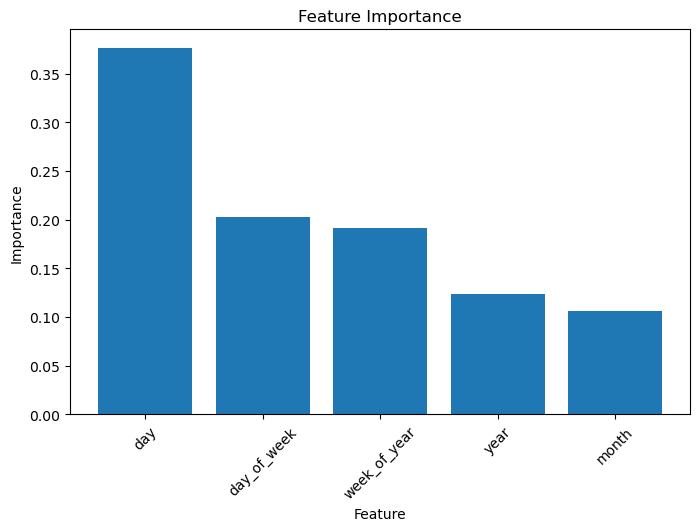

In [15]:
plt.figure(figsize=(8,5))
plt.bar(importance['Feature'], importance['Importance'])
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

## Improved Model with Lag Features

To improve forecasting performance, historical sales information was incorporated 
using lag-based features. These features allow the model to learn short-term demand 
patterns and recent trends.

New features created:
- lag_1 (previous day's sales)
- lag_7 (sales from 7 days ago)
- rolling_mean_7 (7-day moving average)

In [16]:
# Create lag features
daily_sales['lag_1'] = daily_sales['Sales'].shift(1)
daily_sales['lag_7'] = daily_sales['Sales'].shift(7)
daily_sales['rolling_mean_7'] = daily_sales['Sales'].rolling(window=7).mean()

daily_sales = daily_sales.dropna()

In [17]:
features = [
    'day',
    'month',
    'year',
    'day_of_week',
    'week_of_year',
    'lag_1',
    'lag_7',
    'rolling_mean_7'
]

In [ ]:

train = daily_sales[daily_sales.index < '2017-01-01']
test = daily_sales[daily_sales.index >= '2017-01-01']

X_train = train[features]
y_train = train['Sales']

X_test = test[features]
y_test = test['Sales']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [26]:
model_lag = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

model_lag.fit(X_train, y_train)

predictions_lag = model_lag.predict(X_test)
mae_lag = mean_absolute_error(y_test, predictions_lag)
rmse_lag = np.sqrt(mean_squared_error(y_test, predictions_lag))

print("New MAE:", mae_lag)
print("New RMSE:", rmse_lag)

New MAE: 1593.2705479792958
New RMSE: 2230.7519939472063


### Improved Model Performance Analysis

The inclusion of lag-based historical features improved forecasting accuracy.

- MAE decreased from 1675 to 1593.
- RMSE decreased from 2517 to 2230.

This confirms that recent historical sales patterns 
are critical for accurate demand forecasting.

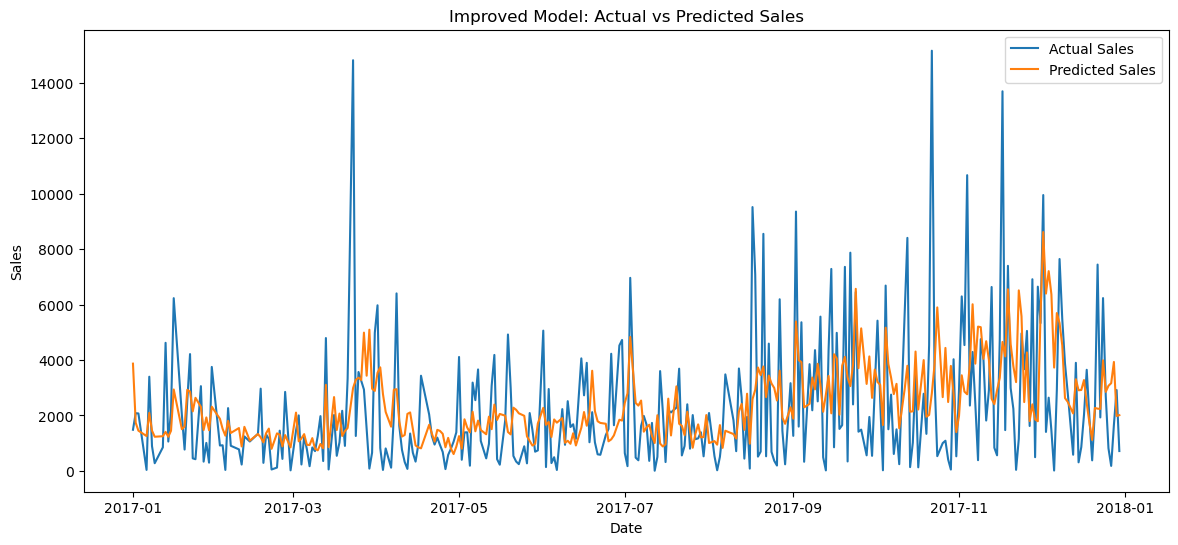

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(test.index, y_test, label="Actual Sales")
plt.plot(test.index, predictions, label="Predicted Sales")
plt.legend()
plt.title("Improved Model: Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [27]:
# Copy latest data for iterative forecasting
forecast_data = daily_sales.copy()

future_predictions = []

# Iterative forecasting for next 30 days
for i in range(30):
    
    last_date = forecast_data.index.max()
    next_date = last_date + pd.Timedelta(days=1)
    
    # Create new row for next date
    new_row = {}
    new_row['day'] = next_date.day
    new_row['month'] = next_date.month
    new_row['year'] = next_date.year
    new_row['day_of_week'] = next_date.dayofweek
    new_row['week_of_year'] = next_date.isocalendar().week
    
    # Lag features
    new_row['lag_1'] = forecast_data['Sales'].iloc[-1]
    new_row['lag_7'] = forecast_data['Sales'].iloc[-7]
    new_row['rolling_mean_7'] = forecast_data['Sales'].iloc[-7:].mean()
    
    # Convert to DataFrame
    new_df = pd.DataFrame(new_row, index=[next_date])
    
    # Predict using IMPROVED model
    next_sales = model_lag.predict(new_df[features])[0]
    
    # Store prediction
    future_predictions.append(next_sales)
    
    # Append prediction to dataset for next iteration
    forecast_data.loc[next_date] = [
        next_sales,
        new_row['day'],
        new_row['month'],
        new_row['year'],
        new_row['day_of_week'],
        new_row['week_of_year'],
        new_row['lag_1'],
        new_row['lag_7'],
        new_row['rolling_mean_7']
    ]

In [28]:
# Create proper future date index
future_index = pd.date_range(
    start=daily_sales.index.max() + pd.Timedelta(days=1),
    periods=30
)

future_predictions_series = pd.Series(
    future_predictions,
    index=future_index
)

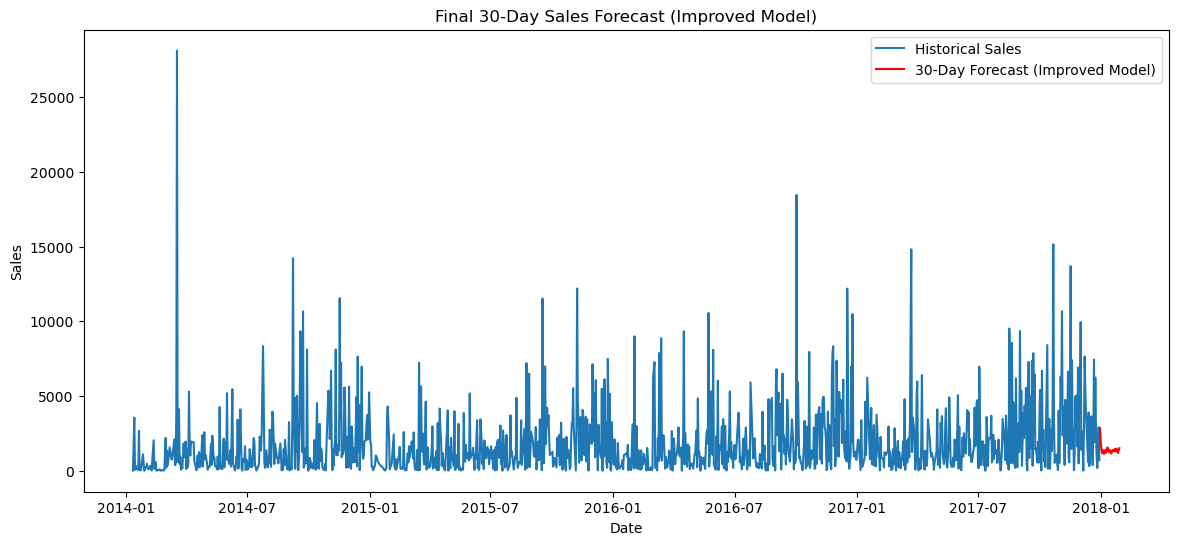

In [29]:
plt.figure(figsize=(14,6))

plt.plot(daily_sales['Sales'], label="Historical Sales")
plt.plot(future_predictions_series, 
         label="30-Day Forecast (Improved Model)", 
         color="red")

plt.legend()
plt.title("Final 30-Day Sales Forecast (Improved Model)")
plt.xlabel("Date")
plt.ylabel("Sales")

plt.show()

## Business Interpretation of Final Forecast

The improved forecasting model incorporating lag features provides 
a more realistic short-term projection of demand.

Key Insights:
- Recent historical sales strongly influence future demand.
- Forecast reflects ongoing volatility in daily sales.
- Predictions align more closely with recent trends compared 
  to the baseline model.

Business Value:
- Supports short-term inventory planning
- Helps optimize staffing levels
- Assists in managing cash flow and procurement decisions

Although extreme spikes remain challenging to predict,
the model offers meaningful guidance for operational planning.

# Final Conclusion

This project successfully developed a time-series sales forecasting system 
using historical retail transaction data.

Two models were evaluated:

### 1️⃣ Baseline Random Forest Model (Calendar Features Only)
- Utilized date-based features such as day, month, year, and seasonality indicators.
- Captured general demand trends but struggled with sharp fluctuations.
- MAE ≈ 1675  
- RMSE ≈ 2517  

### 2️⃣ Improved Model with Lag-Based Features
- Incorporated short-term historical information (lag_1, lag_7, rolling_mean_7).
- Demonstrated measurable performance improvement:
  - MAE reduced to ≈ 1593
  - RMSE reduced to ≈ 2230
- Better captured short-term demand dependencies and recent trends.

### Key Insights

- Temporal patterns strongly influence sales behavior.
- Recent historical sales are critical for improving forecast accuracy.
- Pure calendar features are insufficient for volatile daily demand.
- Iterative forecasting enables realistic short-term projections.

### Business Impact

The final improved forecasting model provides practical value for:

- Inventory optimization  
- Workforce and staffing planning  
- Procurement scheduling  
- Cash flow forecasting  
- Short-term operational decision-making  

Although extreme sales spikes remain challenging to predict, 
the model delivers meaningful and actionable guidance for business planning.

This project demonstrates how machine learning can translate raw transaction data 
into data-driven decision support systems for real-world business environments.